In [6]:
!pip install n2v

In [2]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 35.6 MB/s eta 0:00:00


=== Median Filter Denoising ===
PSNR: 26.04
SSIM: 0.7313
MSE : 0.002486

=== Wavelet Denoising ===
PSNR: 26.23
SSIM: 0.7114
MSE : 0.002382


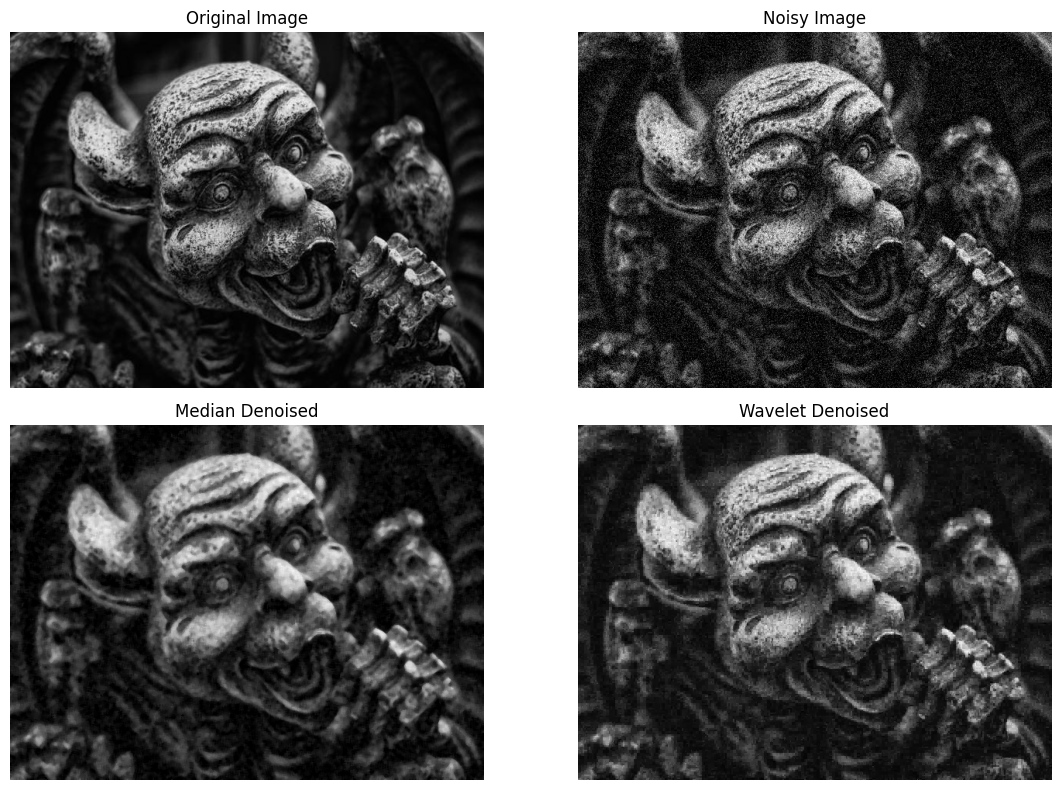

In [3]:
# Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration, metrics
from skimage.util import random_noise

# ---------------------------
# 1. Load the Image
# ---------------------------
img = cv2.imread('devil_image.jpg', cv2.IMREAD_GRAYSCALE)

# Check if image is loaded
if img is None:
    raise ValueError("Image not found. Please check the filename or path.")

# Normalize the image (scale between 0-1)
img = img / 255.0

# ---------------------------
# 2. Add Artificial Gaussian Noise
# ---------------------------
noisy_img = random_noise(img, mode='gaussian')

# ---------------------------
# 3. Apply Denoising Techniques
# ---------------------------

# Median Filter (OpenCV expects 8-bit, then scale back to 0-1)
median_denoised = cv2.medianBlur((noisy_img * 255).astype(np.uint8), 5) / 255.0

# Wavelet Denoising (channel_axis=None is correct for grayscale images)
wavelet_denoised = restoration.denoise_wavelet(noisy_img, mode='soft', wavelet_levels=3, channel_axis=None)

# ---------------------------
# 4. Evaluate Metrics (PSNR, SSIM, MSE)
# ---------------------------

# Median Filter Metrics
psnr_median = metrics.peak_signal_noise_ratio(img, median_denoised)
ssim_median = metrics.structural_similarity(img, median_denoised, data_range=1.0)
mse_median = metrics.mean_squared_error(img, median_denoised)

# Wavelet Filter Metrics
psnr_wavelet = metrics.peak_signal_noise_ratio(img, wavelet_denoised)
ssim_wavelet = metrics.structural_similarity(img, wavelet_denoised, data_range=1.0)
mse_wavelet = metrics.mean_squared_error(img, wavelet_denoised)

# ---------------------------
# 5. Print Results
# ---------------------------
print("=== Median Filter Denoising ===")
print(f"PSNR: {psnr_median:.2f}")
print(f"SSIM: {ssim_median:.4f}")
print(f"MSE : {mse_median:.6f}\n")

print("=== Wavelet Denoising ===")
print(f"PSNR: {psnr_wavelet:.2f}")
print(f"SSIM: {ssim_wavelet:.4f}")
print(f"MSE : {mse_wavelet:.6f}")

# ---------------------------
# 6. Display Images
# ---------------------------

titles = ['Original Image', 'Noisy Image', 'Median Denoised', 'Wavelet Denoised']
images = [img, noisy_img, median_denoised, wavelet_denoised]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.1069
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0738
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0867
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0792
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0643
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 0.0689
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0699
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0642
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0635
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0650
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


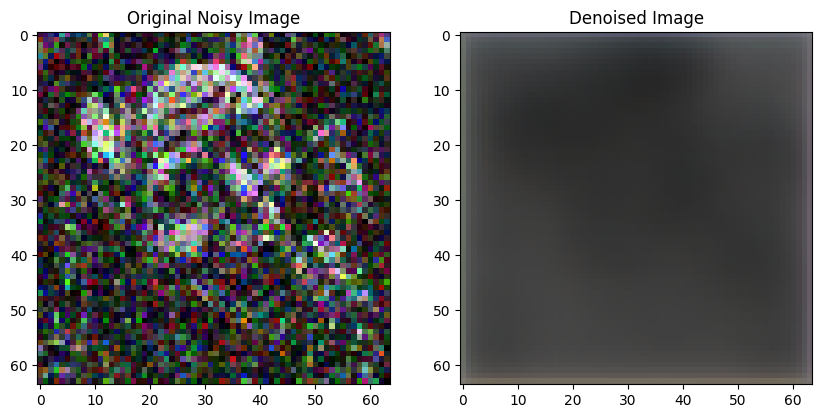

PSNR: 12.118254353647941, SSIM: 0.034555928745653226, MSE: 0.061400875634532316


In [10]:
import numpy as np
import cv2
import tensorflow as tf
from skimage import io
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse

# Step 1: Load your clean image and add noise to it

def add_noise(image, noise_factor=0.3):
    """Add Gaussian noise to the image."""
    noisy_image = image + noise_factor * np.random.randn(*image.shape)
    noisy_image = np.clip(noisy_image, 0, 255)  # Clip to valid pixel range
    return noisy_image

# Load your clean image
image = io.imread('devil_image.jpg')  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB if needed

# Normalize the image to float32 for TensorFlow
image = np.asarray(image, dtype=np.float32) / 255.0

# Add noise to the image
noisy_image = add_noise(image)

# Step 2: Build the Noise2Void Model (Simple U-Net)

def build_n2v_model(input_shape):
    """Build a U-Net-like model for denoising."""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 3: Prepare patches for training

def generate_patches(image, patch_size=64, stride=32):
    """Generate patches from the image for self-supervised learning."""
    patches = []
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size]
            mask = np.ones_like(patch)
            mask[patch_size//2, patch_size//2] = 0  # Mask the center pixel
            patches.append((patch, mask))
    return patches

# Generate patches from the noisy image (resize to 64x64 if the image is not already)
noisy_image_resized = cv2.resize(noisy_image, (64, 64))  # Resize to 64x64
patches = generate_patches(noisy_image_resized)
X_train = np.array([patch[0] for patch in patches])
y_train = np.array([patch[0] * patch[1] for patch in patches])  # Apply mask to patches

# Step 4: Train the model

model = build_n2v_model((64, 64, 3))  # Model now accepts 64x64 input size

# Train the model using the generated patches
model.fit(X_train, y_train, epochs=10, batch_size=8)

# Step 5: Evaluate the model

# Ensure the input image is resized to 64x64 before prediction
denoised_image = model.predict(np.expand_dims(noisy_image_resized, axis=0))[0]

# Step 6: Calculate PSNR, SSIM, and MSE

# PSNR Calculation
psnr_value = psnr(noisy_image_resized, denoised_image, data_range=1.0)

# SSIM Calculation
ssim_value = ssim(noisy_image_resized, denoised_image, multichannel=True, win_size=3, channel_axis=-1, data_range=1.0)
# MSE Calculation per channel
mse_value = np.mean([mse(noisy_image_resized[..., i].flatten(), denoised_image[..., i].flatten()) for i in range(noisy_image_resized.shape[2])])

# Step 7: Display the original and denoised images

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Noisy Image")
plt.imshow(noisy_image_resized)
plt.subplot(1, 2, 2)
plt.title("Denoised Image")
plt.imshow(denoised_image)
plt.show()

# Print the evaluation metrics
print(f"PSNR: {psnr_value}, SSIM: {ssim_value}, MSE: {mse_value}")


In [11]:
def extract_frames(video_path, output_folder, frame_interval=1):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Open video file
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save frame at specified interval
        if frame_count % frame_interval == 0:
            frame_name = f"frame_{saved_count:04d}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_name), frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Extracted {saved_count} frames from {frame_count} total frames")

# Example usage
extract_frames('/content/videoplayback.mp4', 'output_frames')


Extracted 317 frames from 317 total frames


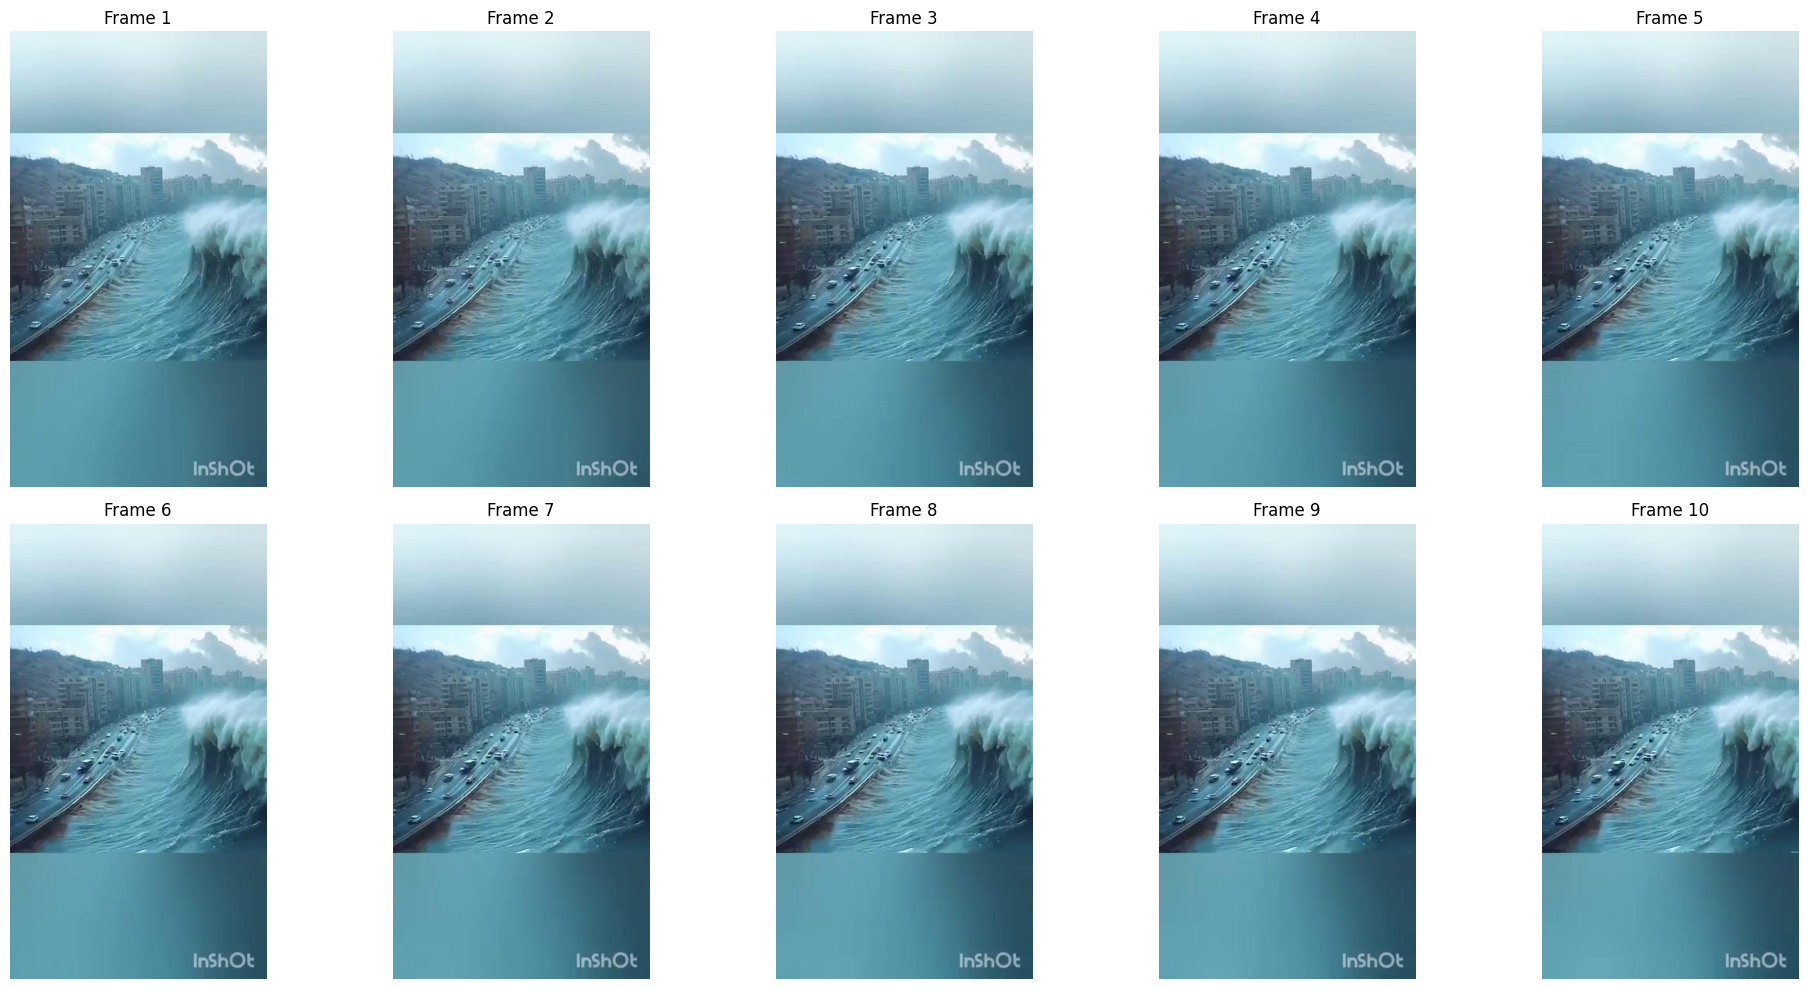

In [12]:
import cv2
import os
import matplotlib.pyplot as plt

def show_first_n_frames(frames_folder, n=10):
    # Get list of frame files sorted by name
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')])

    # Create figure
    plt.figure(figsize=(20, 10))

    # Display first n frames
    for i, frame_file in enumerate(frame_files[:n]):
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib

        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(frame)
        plt.title(f"Frame {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
show_first_n_frames('output_frames', 10)


In [13]:
def process_video(input_path, output_path, operation='threshold'):
    cap = cv2.VideoCapture(input_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height), isColor=False)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Apply selected operation
        if operation == 'threshold':
            processed = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY, 11, 2)
        elif operation == 'gaussian':
            processed = cv2.GaussianBlur(gray, (5, 5), 0)
        elif operation == 'canny':
            processed = cv2.Canny(gray, 100, 200)
        elif operation == 'bitwise_not':
            processed = cv2.bitwise_not(gray)

        # Write processed frame
        out.write(processed)

    cap.release()
    out.release()
    print(f"Processed video saved to {output_path}")

# Example usage
process_video('/content/videoplayback.mp4', 'threshold_output.mp4', 'threshold')
process_video('/content/videoplayback.mp4', 'gaussian_output.mp4', 'gaussian')
process_video('/content/videoplayback.mp4', 'canny_output.mp4', 'canny')
process_video('/content/videoplayback.mp4', 'bitwise_output.mp4', 'bitwise_not')


Processed video saved to threshold_output.mp4
Processed video saved to gaussian_output.mp4
Processed video saved to canny_output.mp4
Processed video saved to bitwise_output.mp4


In [14]:
def create_collage(video_path, output_path, grid_size=(3, 3)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_select = grid_size[0] * grid_size[1]
    step = max(1, total_frames // frames_to_select)

    selected_frames = []
    for i in range(frames_to_select):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if ret:
            selected_frames.append(frame)

    cap.release()

    if len(selected_frames) < frames_to_select:
        print(f"Warning: Only got {len(selected_frames)} frames, expected {frames_to_select}")
        grid_size = (int(np.sqrt(len(selected_frames))), int(np.sqrt(len(selected_frames))))

    # Resize frames to same size
    h, w = selected_frames[0].shape[:2]
    resized_frames = [cv2.resize(f, (w//2, h//2)) for f in selected_frames]

    # Create collage
    rows = []
    for i in range(grid_size[0]):
        row = np.hstack(resized_frames[i*grid_size[1]:(i+1)*grid_size[1]])
        rows.append(row)

    collage = np.vstack(rows)
    cv2.imwrite(output_path, collage)
    print(f"Collage saved to {output_path}")

# Example usage
create_collage('/content/videoplayback.mp4', 'collage.jpg')


Collage saved to collage.jpg


In [ ]:
#task 2

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pevogam/ucf101")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ucf101


In [ ]:
import shutil

# Move the extracted dataset to /content
shutil.copytree('/kaggle/input/ucf101', '/content/UCF101')


'/content/UCF101'

In [ ]:
import os
import cv2
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense


In [ ]:
# Settings
DATASET_PATH = '/content//UCF101/UCF101/UCF-101/'  # path where UCF101 extracted
selected_classes = ['Basketball', 'Typing', 'GolfSwing', 'WalkingWithDog', 'PlayingGuitar']
frames_per_video = 16
img_height, img_width = 112, 112

def load_ucf101_data(dataset_path, selected_classes, frames=16):
    X = []
    y = []

    for class_name in selected_classes:
        class_path = os.path.join(dataset_path, class_name)
        video_files = os.listdir(class_path)

        for video_file in video_files:
            video_path = os.path.join(class_path, video_file)
            frames_list = []

            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            if total_frames < frames:
                continue  # skip videos with too few frames

            frame_indices = np.linspace(0, total_frames-1, frames, dtype=int)

            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.resize(frame, (img_width, img_height))
                    frame = frame / 255.0
                    frames_list.append(frame)
                else:
                    break

            cap.release()

            if len(frames_list) == frames:
                X.append(frames_list)
                y.append(class_name)

    return np.array(X), np.array(y)

# Load dataset
X, y = load_ucf101_data(DATASET_PATH, selected_classes, frames=frames_per_video)

print("Data loaded:", X.shape, y.shape)


Data loaded: (666, 16, 112, 112, 3) (666,)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode
y_encoded = tf.keras.utils.to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

num_classes = len(selected_classes)


Train: (532, 16, 112, 112, 3) (532, 5)
Test: (134, 16, 112, 112, 3) (134, 5)


In [ ]:
# Define model
model = Sequential([
    Conv3D(32, (3,3,3), activation='relu', padding='same', input_shape=(frames_per_video, img_height, img_width, 3)),
    MaxPooling3D((2,2,2)),

    Conv3D(64, (3,3,3), activation='relu', padding='same'),
    MaxPooling3D((2,2,2)),

    Conv3D(128, (3,3,3), activation='relu', padding='same'),
    GlobalAveragePooling3D(),

    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 16, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 8, 56, 56, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 8, 56, 56, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 4, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 313,605 (1.20 MB)

 Trainable params: 313,605 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)


Class weights: {0: np.float64(1.064), 1: np.float64(1.0431372549019609), 2: np.float64(0.83125), 3: np.float64(0.9761467889908257), 4: np.float64(1.1440860215053763)}


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=8,
    class_weight=class_weights
)


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.1747 - loss: 1.6265 - val_accuracy: 0.3284 - val_loss: 1.5479
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.3163 - loss: 1.5046 - val_accuracy: 0.3284 - val_loss: 1.2487
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.4545 - loss: 1.2015 - val_accuracy: 0.4627 - val_loss: 1.1052
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.4773 - loss: 1.0975 - val_accuracy: 0.5299 - val_loss: 1.0906
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5662 - loss: 1.0801 - val_accuracy: 0.5746 - val_loss: 0.9766
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.5508 - loss: 1.0174 - val_accuracy: 0.6343 - val_loss: 0.8725
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6355 - loss: 0.9121 - val_accuracy: 0.6567 - val_loss: 0.8158
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6552 - loss: 0.7995 - val_accuracy: 0.6791 

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8118 - loss: 0.9082
Test Loss: 0.8519, Test Accuracy: 0.8209
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step

Classification Report:
                precision    recall  f1-score   support

    Basketball       0.68      0.60      0.64        25
     GolfSwing       1.00      0.58      0.73        26
 PlayingGuitar       0.86      1.00      0.93        32
        Typing       0.93      1.00      0.96        27
WalkingWithDog       0.68      0.88      0.76        24

      accuracy                           0.82       134
     macro avg       0.83      0.81      0.81       134
  weighted avg       0.84      0.82      0.81       134


Confusion Matrix:
[[15  0  5  0  5]
 [ 4 15  0  2  5]
 [ 0  0 32  0  0]
 [ 0  0  0 27  0]
 [ 3  0  0  0 21]]
